# OBIETTIVO: core value analysis



In [7]:
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.tenalg import mode_dot, multi_mode_dot
import kagglehub
import h5py
from tqdm import tqdm
import pandas as pd
import kagglehub
import global_variables

In [8]:
n_snapshots = 200
subsample_x = 10
subsample_y = 10
paths = ["sharmapushan/hydrogen-jet-10000"]
data_paths = [kagglehub.dataset_download(name) for name in paths]
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)
Nx, Ny = metadata['global']['Nxyz']
Nx_sub = Nx // subsample_x
Ny_sub = Ny // subsample_y
component_names = global_variables.component_names
n_species = global_variables.n_species
molar_masses = global_variables.molar_masses
file_key_map = global_variables.file_key_map
Lx, Ly = global_variables.Lx, global_variables.Ly


In [9]:
tensors = {}
for data_path in data_paths:
    key = data_path.split('/')[-3]
    print(f"{key}")
    tensor = np.zeros((Ny//subsample_y, Nx//subsample_x, n_species, n_snapshots))
    for t_idx in range(n_snapshots):
        for new_idx, (comp_name, orig_idx) in enumerate(zip(component_names, range(n_species))):
            filename_key = file_key_map[comp_name]
            filename = metadata['local'][t_idx][filename_key]
            data = np.fromfile(f"{data_path}/{filename}", dtype='<f4').reshape(Ny, Nx)
            molar_data = data / molar_masses[comp_name]
            tensor[:, :, new_idx, t_idx] = molar_data[::subsample_x, ::subsample_y]
    tensors[key] = tensor
            

hydrogen-jet-10000


In [10]:
def scale_and_center_tensors(tensors, component_names, log_scale=True, 
                             temporal_m=False, std_scale=True, epsilon=1e-12):
    tensors_scaled = {}
    
    for dataset_path, tensor in tensors.items():
        tensor_scaled = tensor.copy()  # Shape: (x, y, species, t)        
        for c_idx, comp_name in enumerate(component_names):
            component_data = tensor_scaled[:, :, c_idx, :].copy()            
            if log_scale:
                component_data = np.log10(np.maximum(component_data, epsilon))
            if temporal_m:
                temporal_mean = component_data.mean(axis=-1, keepdims=True)  # Mean over time
                component_data = component_data - temporal_mean
            if std_scale:
                mean_val = component_data.mean()  # Should be ~0 if temporal_m=True
                std_val = component_data.std()                
                if std_val < epsilon:
                    std_val = epsilon  # Prevent divide-by-zero
                
                component_data = (component_data - mean_val) / std_val
            
            # Store processed component
            tensor_scaled[:, :, c_idx, :] = component_data
        
        tensors_scaled[dataset_path] = tensor_scaled
    
    return tensors_scaled

In [13]:
tensor_std = scale_and_center_tensors(tensors, component_names, log_scale=True, temporal_m=True, std_scale=True)
tensors_scaled_nostd = scale_and_center_tensors(tensors, component_names, log_scale=True, temporal_m=True, std_scale=False)


In [14]:
decomposition_results = {}  # store factors and cores per dataset

# HOSVD for non-standard scaled tensors
for dataset_path, tensor in tensors_scaled_nostd.items():
    print("\n" + "=" * 100)
    print(f"Performing HOSVD for dataset (no std scale): {dataset_path}")
    print("=" * 100)
    print(f"Tensor shape: (Ny={tensor.shape[0]}, Nx={tensor.shape[1]}, n_chem={tensor.shape[2]}, n_time={tensor.shape[3]})")
    
    # Compute factor matrices for each mode
    print("Computing U_y (mode 0: spatial Y)...")
    U_y, _, _ = np.linalg.svd(tl.unfold(tensor, mode=0), full_matrices=False)
    
    print("Computing U_x (mode 1: spatial X)...")
    U_x, _, _ = np.linalg.svd(tl.unfold(tensor, mode=1), full_matrices=False)
    
    print("Computing U_chem (mode 2: chemical)...")
    U_chem, _, _ = np.linalg.svd(tl.unfold(tensor, mode=2), full_matrices=False)
    
    print("Computing U_time (mode 3: time)...")
    U_time, _, _ = np.linalg.svd(tl.unfold(tensor, mode=3), full_matrices=False)
    
    # Compute core tensor
    print("Computing core tensor...")
    core = multi_mode_dot(tensor, [U_y.T, U_x.T, U_chem.T, U_time.T], modes=[0, 1, 2, 3])
    
    decomposition_results[dataset_path + "_nostd"] = {
        "core": core,
        "U_y": U_y,
        "U_x": U_x,
        "U_chem": U_chem,
        "U_time": U_time,
        "factors": [U_y, U_x, U_chem, U_time],  # Keep for backward compatibility
    }

# HOSVD for standard scaled tensors
for dataset_path, tensor in tensor_std.items():
    print("\n" + "=" * 100)
    print(f"Performing HOSVD for dataset (with std scale): {dataset_path}")
    print("=" * 100)
    print(f"Tensor shape: (Ny={tensor.shape[0]}, Nx={tensor.shape[1]}, n_chem={tensor.shape[2]}, n_time={tensor.shape[3]})")
    
    # Compute factor matrices for each mode
    print("Computing U_y (mode 0: spatial Y)...")
    U_y, _, _ = np.linalg.svd(tl.unfold(tensor, mode=0), full_matrices=False)
    
    print("Computing U_x (mode 1: spatial X)...")
    U_x, _, _ = np.linalg.svd(tl.unfold(tensor, mode=1), full_matrices=False)
    
    print("Computing U_chem (mode 2: chemical)...")
    U_chem, _, _ = np.linalg.svd(tl.unfold(tensor, mode=2), full_matrices=False)
    
    print("Computing U_time (mode 3: time)...")
    U_time, _, _ = np.linalg.svd(tl.unfold(tensor, mode=3), full_matrices=False)
    
    # Compute core tensor
    print("Computing core tensor...")
    core = multi_mode_dot(tensor, [U_y.T, U_x.T, U_chem.T, U_time.T], modes=[0, 1, 2, 3])
    
    decomposition_results[dataset_path + "_std"] = {
        "core": core,
        "U_y": U_y,
        "U_x": U_x,
        "U_chem": U_chem,
        "U_time": U_time,
        "factors": [U_y, U_x, U_chem, U_time],  # Keep for backward compatibility
    }


Performing HOSVD for dataset (no std scale): hydrogen-jet-10000
Tensor shape: (Ny=200, Nx=160, n_chem=8, n_time=200)
Computing U_y (mode 0: spatial Y)...


Computing U_x (mode 1: spatial X)...
Computing U_chem (mode 2: chemical)...
Computing U_time (mode 3: time)...
Computing core tensor...

Performing HOSVD for dataset (with std scale): hydrogen-jet-10000
Tensor shape: (Ny=200, Nx=160, n_chem=8, n_time=200)
Computing U_y (mode 0: spatial Y)...
Computing U_x (mode 1: spatial X)...
Computing U_chem (mode 2: chemical)...
Computing U_time (mode 3: time)...
Computing core tensor...


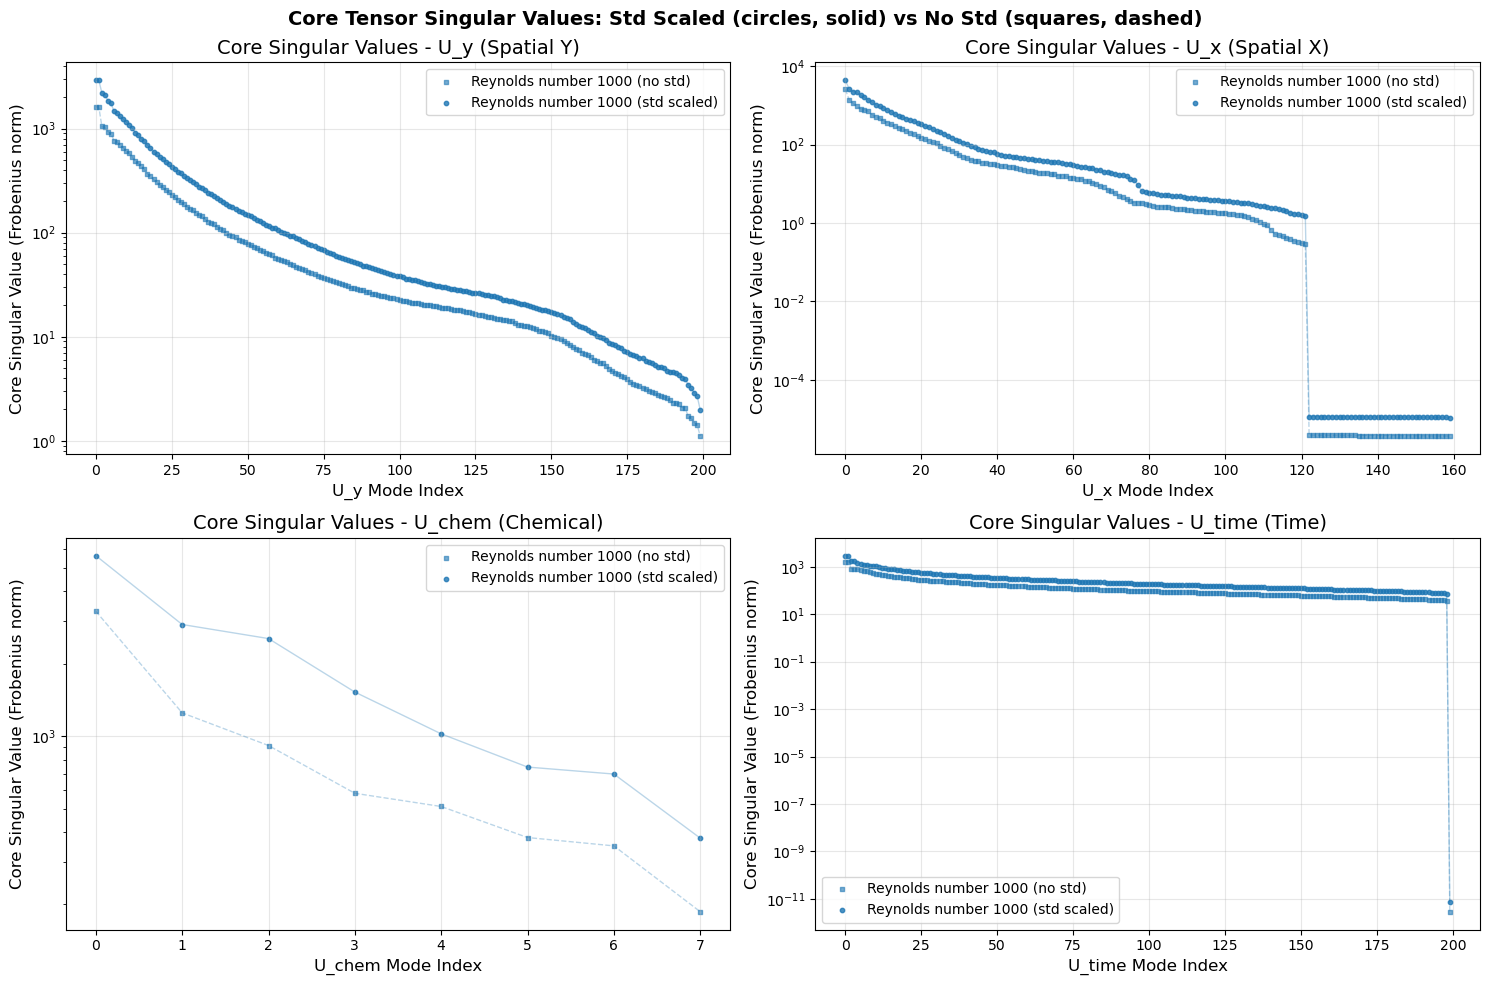

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Group results by dataset (ignoring _std/_nostd suffix)
dataset_groups = {}
for key in decomposition_results.keys():
    base_key = key.replace('_std', '').replace('_nostd', '')
    if base_key not in dataset_groups:
        dataset_groups[base_key] = {}
    if '_std' in key:
        dataset_groups[base_key]['std'] = decomposition_results[key]
    else:
        dataset_groups[base_key]['nostd'] = decomposition_results[key]

colors = plt.cm.tab10(np.linspace(0, 1, len(dataset_groups)))

for idx, (base_key, variants) in enumerate(dataset_groups.items()):
    dataset_name = f"Reynolds number {base_key.split('-')[-1][:4]}"
    color = colors[idx]
    
    # Plot both std and nostd variants
    for variant_name, variant_data in variants.items():
        core = variant_data['core']
        
        # Use different markers and line styles for std vs nostd
        if variant_name == 'std':
            marker = 'o'
            linestyle = '-'
            alpha_scatter = 0.8
            alpha_line = 0.3
            label = f"{dataset_name} (std scaled)"
        else:
            marker = 's'
            linestyle = '--'
            alpha_scatter = 0.6
            alpha_line = 0.3
            label = f"{dataset_name} (no std)"
        
        # Spatial Y dimension (U_y)
        sv_y = [np.linalg.norm(core[i, :, :, :]) for i in range(core.shape[0])]
        ax = axes[0, 0]
        ax.scatter(range(len(sv_y)), sv_y, color=color, s=10, alpha=alpha_scatter, 
                   label=label, marker=marker)
        ax.plot(range(len(sv_y)), sv_y, color=color, alpha=alpha_line, 
                linewidth=1, linestyle=linestyle)
        
        # Spatial X dimension (U_x)
        sv_x = [np.linalg.norm(core[:, i, :, :]) for i in range(core.shape[1])]
        ax = axes[0, 1]
        ax.scatter(range(len(sv_x)), sv_x, color=color, s=10, alpha=alpha_scatter, 
                   label=label, marker=marker)
        ax.plot(range(len(sv_x)), sv_x, color=color, alpha=alpha_line, 
                linewidth=1, linestyle=linestyle)
        
        # Chemical dimension (U_chem)
        sv_chem = [np.linalg.norm(core[:, :, i, :]) for i in range(core.shape[2])]
        ax = axes[1, 0]
        ax.scatter(range(len(sv_chem)), sv_chem, color=color, s=10, alpha=alpha_scatter, 
                   label=label, marker=marker)
        ax.plot(range(len(sv_chem)), sv_chem, color=color, alpha=alpha_line, 
                linewidth=1, linestyle=linestyle)
        
        # Time dimension (U_time)
        sv_time = [np.linalg.norm(core[:, :, :, i]) for i in range(core.shape[3])]
        ax = axes[1, 1]
        ax.scatter(range(len(sv_time)), sv_time, color=color, s=10, alpha=alpha_scatter, 
                   label=label, marker=marker)
        ax.plot(range(len(sv_time)), sv_time, color=color, alpha=alpha_line, 
                linewidth=1, linestyle=linestyle)

ax = axes[0, 0]
ax.set_xlabel('U_y Mode Index', fontsize=12)
ax.set_ylabel('Core Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Core Singular Values - U_y (Spatial Y)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=10, loc='best')

ax = axes[0, 1]
ax.set_xlabel('U_x Mode Index', fontsize=12)
ax.set_ylabel('Core Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Core Singular Values - U_x (Spatial X)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=10, loc='best')

ax = axes[1, 0]
ax.set_xlabel('U_chem Mode Index', fontsize=12)
ax.set_ylabel('Core Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Core Singular Values - U_chem (Chemical)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=10, loc='best')

ax = axes[1, 1]
ax.set_xlabel('U_time Mode Index', fontsize=12)
ax.set_ylabel('Core Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Core Singular Values - U_time (Time)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=10, loc='best')

fig.suptitle('Core Tensor Singular Values: Std Scaled (circles, solid) vs No Std (squares, dashed)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()

plt.show()

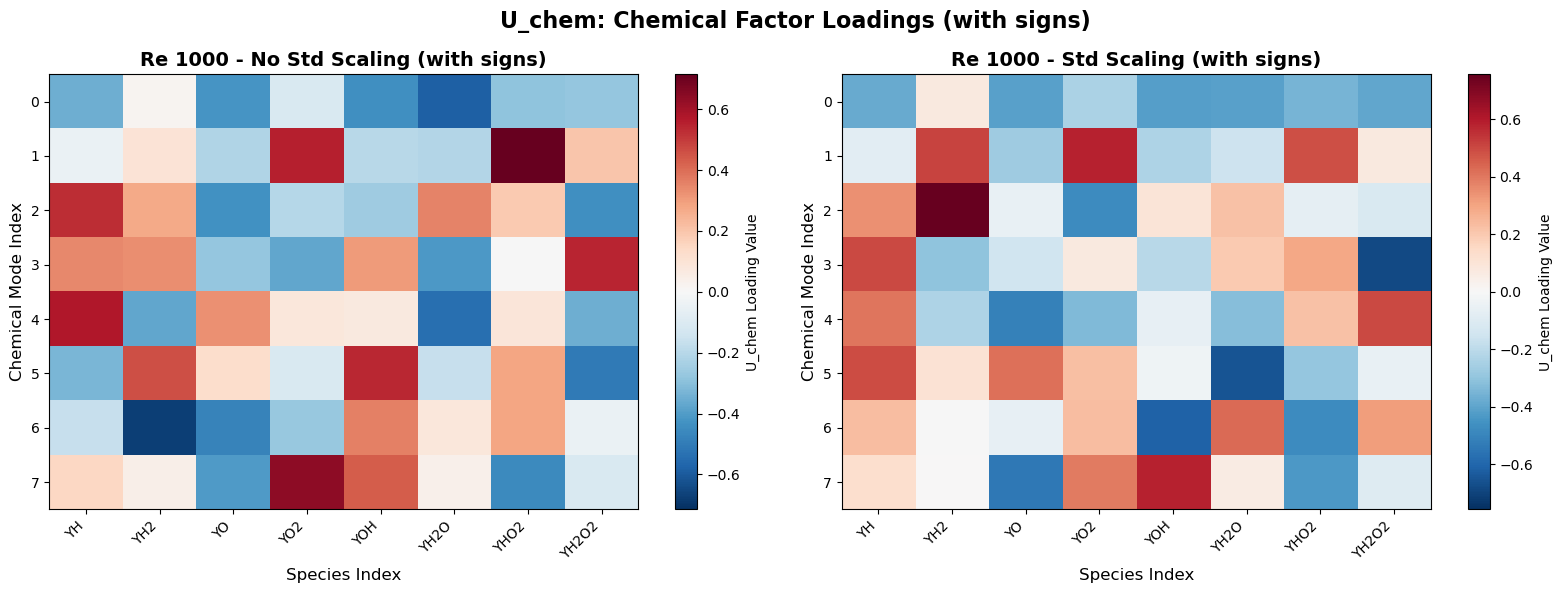

In [16]:
# Visualize Chemical Loadings with Signs
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (base_key, variants) in enumerate(dataset_groups.items()):
    dataset_name = f"Re {base_key.split('-')[-1][:4]}"
    
    # Get U_chem for both variants
    if 'nostd' in variants:
        U_chem_nostd = variants['nostd']['U_chem']  # shape: (n_species, n_species)
        # Plot with signs
        ax = axes[0]
        im0 = ax.imshow(U_chem_nostd.T, cmap='RdBu_r', aspect='auto', 
                        vmin=-np.abs(U_chem_nostd).max(), 
                        vmax=np.abs(U_chem_nostd).max())
        ax.set_xlabel('Species Index', fontsize=12)
        ax.set_ylabel('Chemical Mode Index', fontsize=12)
        ax.set_title(f'{dataset_name} - No Std Scaling (with signs)', fontsize=14, fontweight='bold')
        ax.set_xticks(range(len(component_names)))
        ax.set_xticklabels(component_names, rotation=45, ha='right')
        plt.colorbar(im0, ax=ax, label='U_chem Loading Value')
    
    if 'std' in variants:
        U_chem_std = variants['std']['U_chem']
        # Plot with signs
        ax = axes[1]
        im1 = ax.imshow(U_chem_std.T, cmap='RdBu_r', aspect='auto',
                        vmin=-np.abs(U_chem_std).max(), 
                        vmax=np.abs(U_chem_std).max())
        ax.set_xlabel('Species Index', fontsize=12)
        ax.set_ylabel('Chemical Mode Index', fontsize=12)
        ax.set_title(f'{dataset_name} - Std Scaling (with signs)', fontsize=14, fontweight='bold')
        ax.set_xticks(range(len(component_names)))
        ax.set_xticklabels(component_names, rotation=45, ha='right')
        plt.colorbar(im1, ax=ax, label='U_chem Loading Value')

fig.suptitle('U_chem: Chemical Factor Loadings (with signs)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

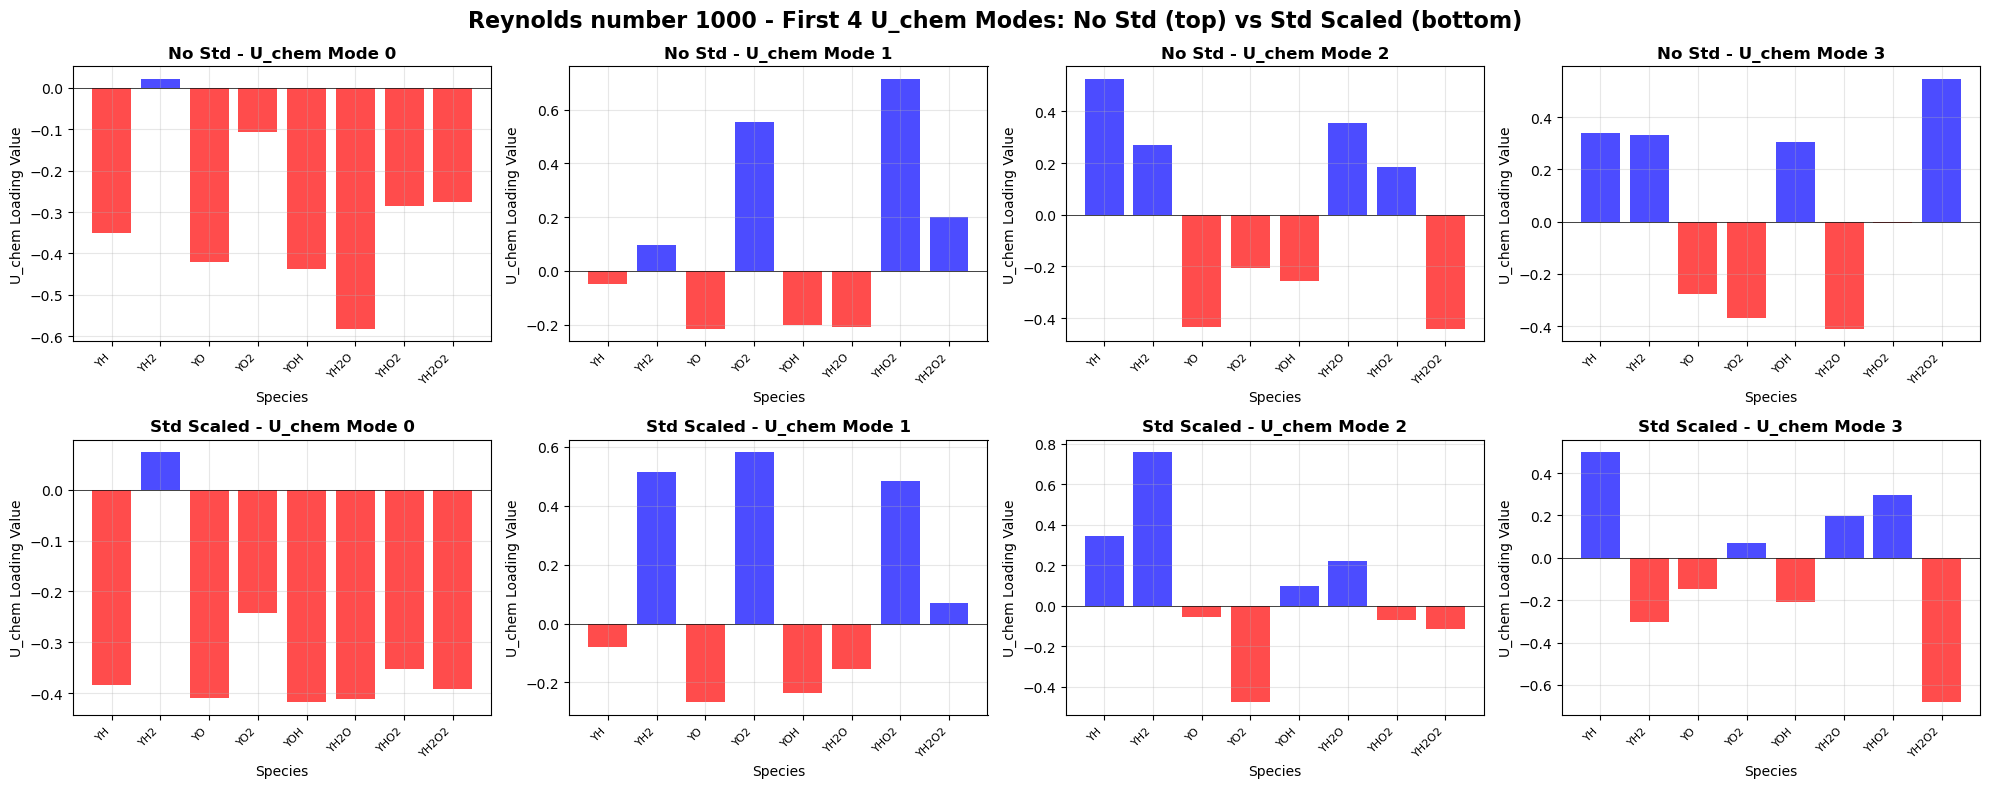

In [17]:
# Visualize first few chemical modes as bar plots for detailed comparison
n_modes_to_show = min(4, len(component_names))

for idx, (base_key, variants) in enumerate(dataset_groups.items()):
    dataset_name = f"Reynolds number {base_key.split('-')[-1][:4]}"
    
    fig, axes = plt.subplots(2, n_modes_to_show, figsize=(20, 8))
    
    if 'nostd' in variants and 'std' in variants:
        U_chem_nostd = variants['nostd']['U_chem']
        U_chem_std = variants['std']['U_chem']
        
        x = np.arange(len(component_names))
        
        for mode_idx in range(n_modes_to_show):
            # No Std Scaling
            ax_nostd = axes[0, mode_idx] if n_modes_to_show > 1 else axes[0]
            values_nostd = U_chem_nostd[:, mode_idx]
            colors_nostd = ['red' if v < 0 else 'blue' for v in values_nostd]
            ax_nostd.bar(x, values_nostd, color=colors_nostd, alpha=0.7)
            ax_nostd.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            ax_nostd.set_xlabel('Species', fontsize=10)
            ax_nostd.set_ylabel('U_chem Loading Value', fontsize=10)
            ax_nostd.set_title(f'No Std - U_chem Mode {mode_idx}', fontsize=12, fontweight='bold')
            ax_nostd.set_xticks(x)
            ax_nostd.set_xticklabels(component_names, rotation=45, ha='right', fontsize=8)
            ax_nostd.grid(True, alpha=0.3)
            
            # Std Scaling
            ax_std = axes[1, mode_idx] if n_modes_to_show > 1 else axes[1]
            values_std = U_chem_std[:, mode_idx]
            colors_std = ['red' if v < 0 else 'blue' for v in values_std]
            ax_std.bar(x, values_std, color=colors_std, alpha=0.7)
            ax_std.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            ax_std.set_xlabel('Species', fontsize=10)
            ax_std.set_ylabel('U_chem Loading Value', fontsize=10)
            ax_std.set_title(f'Std Scaled - U_chem Mode {mode_idx}', fontsize=12, fontweight='bold')
            ax_std.set_xticks(x)
            ax_std.set_xticklabels(component_names, rotation=45, ha='right', fontsize=8)
            ax_std.grid(True, alpha=0.3)
        
        fig.suptitle(f'{dataset_name} - First {n_modes_to_show} U_chem Modes: No Std (top) vs Std Scaled (bottom)', 
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

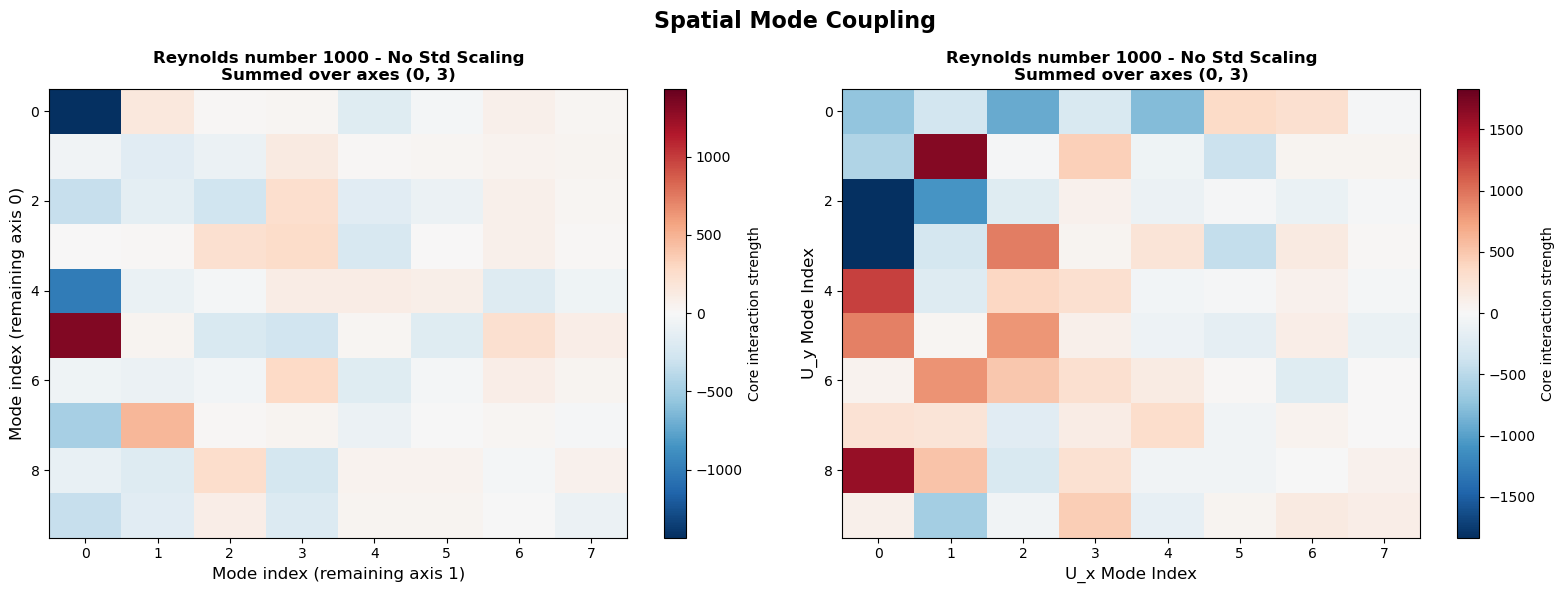

In [22]:
for idx, (base_key, variants) in enumerate(dataset_groups.items()):
    sum_axes = (0, 3)

    dataset_name = f"Reynolds number {base_key.split('-')[-1][:4]}"
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if 'nostd' in variants:
        core_nostd = variants['nostd']['core']

        spatial_coupling_nostd = np.sum(core_nostd, axis=sum_axes)[:10, :20]

        ax = axes[0]
        im0 = ax.imshow(
            spatial_coupling_nostd,
            cmap='RdBu_r',
            aspect='auto',
            vmin=-np.abs(spatial_coupling_nostd).max(),
            vmax=np.abs(spatial_coupling_nostd).max()
        )

        ax.set_xlabel('Mode index (remaining axis 1)', fontsize=12)
        ax.set_ylabel('Mode index (remaining axis 0)', fontsize=12)
        ax.set_title(
            f"{dataset_name} - No Std Scaling\nSummed over axes {sum_axes}",
            fontsize=12,
            fontweight='bold'
        )
        plt.colorbar(im0, ax=ax, label='Core interaction strength')
    if 'std' in variants:
        core_std = variants['std']['core']
        spatial_coupling_std = np.sum(core_std, axis=sum_axes)[:10, :20]
        ax = axes[1]
        im1 = ax.imshow(
            spatial_coupling_std,
            cmap='RdBu_r',
            aspect='auto',
            vmin=-np.abs(spatial_coupling_std).max(),
            vmax=np.abs(spatial_coupling_std).max()
        )

        ax.set_xlabel('U_x Mode Index', fontsize=12)
        ax.set_ylabel('U_y Mode Index', fontsize=12)
        ax.set_title(
            f"{dataset_name} - No Std Scaling\nSummed over axes {sum_axes}",

            fontsize=12,
            fontweight='bold'
        )
        plt.colorbar(im1, ax=ax, label='Core interaction strength')

    fig.suptitle(
        f"Spatial Mode Coupling",
        fontsize=16,
        fontweight='bold'
    )
    plt.tight_layout()
    plt.show()


# Core tensor analysis

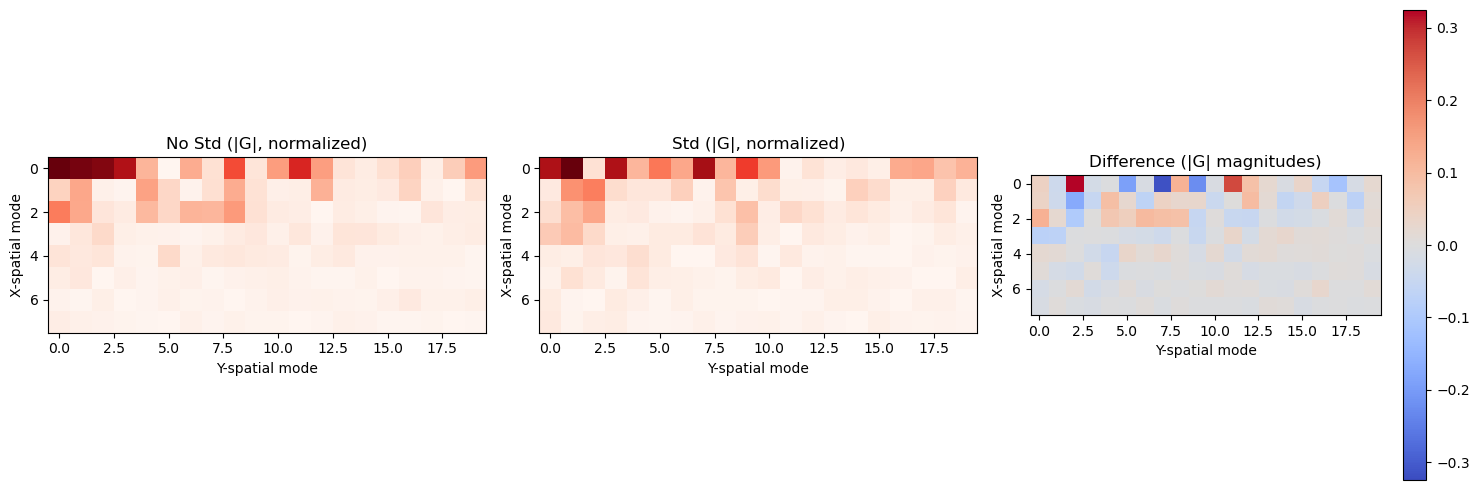

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Use absolute values for fair comparison
spatial_coupling_nostd_abs = np.abs(spatial_coupling_nostd)
spatial_coupling_std_abs = np.abs(spatial_coupling_std)

# Normalize by Frobenius norm
norm_nostd = np.linalg.norm(spatial_coupling_nostd_abs, 'fro')
norm_std = np.linalg.norm(spatial_coupling_std_abs, 'fro')

axes[0].imshow(spatial_coupling_nostd_abs / norm_nostd, cmap='Reds')  # Use 'Reds' for positive-only
axes[0].set_xlabel('Y-spatial mode')
axes[0].set_ylabel('X-spatial mode')
axes[0].set_title("No Std (|G|, normalized)")

axes[1].imshow(spatial_coupling_std_abs / norm_std, cmap='Reds')
axes[1].set_xlabel('Y-spatial mode')
axes[1].set_ylabel('X-spatial mode')
axes[1].set_title("Std (|G|, normalized)")

# Difference in magnitudes
diff = (spatial_coupling_nostd_abs / norm_nostd) - (spatial_coupling_std_abs / norm_std)
im = axes[2].imshow(diff, cmap='coolwarm', vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
axes[2].set_xlabel('Y-spatial mode')
axes[2].set_ylabel('X-spatial mode')
axes[2].set_title("Difference (|G| magnitudes)")
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

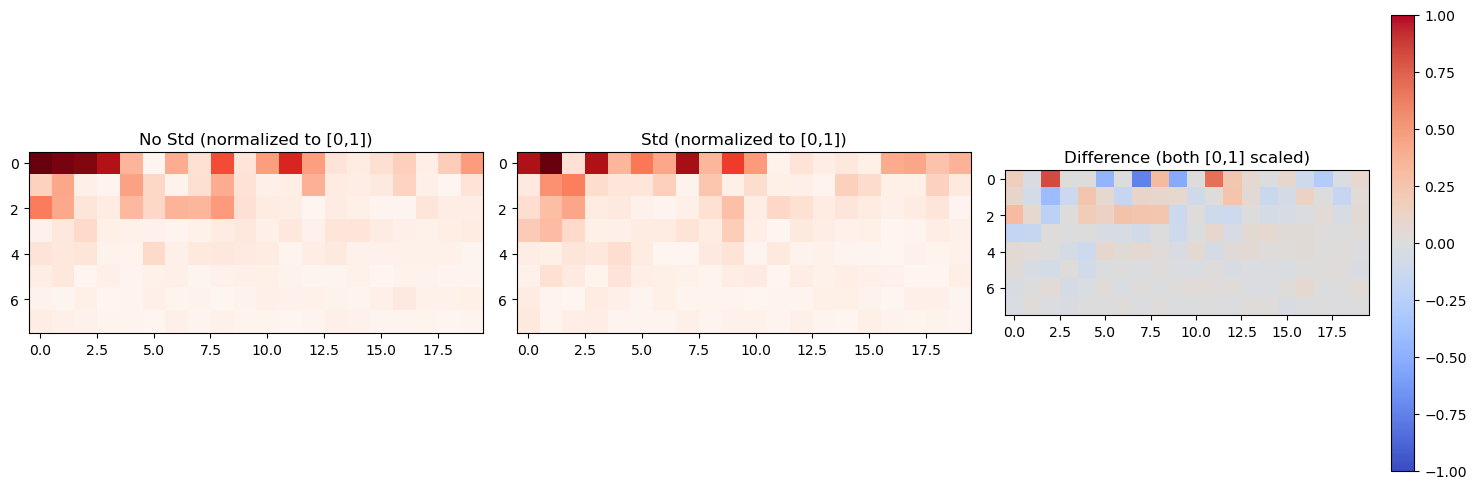

In [20]:
def normalize_matrix_01(M):
    """Normalize all elements to [0, 1] range"""
    M_min = np.min(M)
    M_max = np.max(M)
    
    if M_max == M_min:
        return np.zeros_like(M)
    
    return (M - M_min) / (M_max - M_min)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Method 1: Normalize each separately (shows internal structure)
G_nostd_norm = normalize_matrix_01(np.abs(spatial_coupling_nostd))
G_std_norm = normalize_matrix_01(np.abs(spatial_coupling_std))

axes[0].imshow(G_nostd_norm, cmap='Reds', vmin=0, vmax=1)
axes[0].set_title("No Std (normalized to [0,1])")

axes[1].imshow(G_std_norm, cmap='Reds', vmin=0, vmax=1)
axes[1].set_title("Std (normalized to [0,1])")

# Method 2: Difference (now both on same scale)
diff = G_nostd_norm - G_std_norm
im = axes[2].imshow(diff, cmap='coolwarm', vmin=-1, vmax=1)
axes[2].set_title("Difference (both [0,1] scaled)")
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

Computing coupling metrics and creating visualizations...


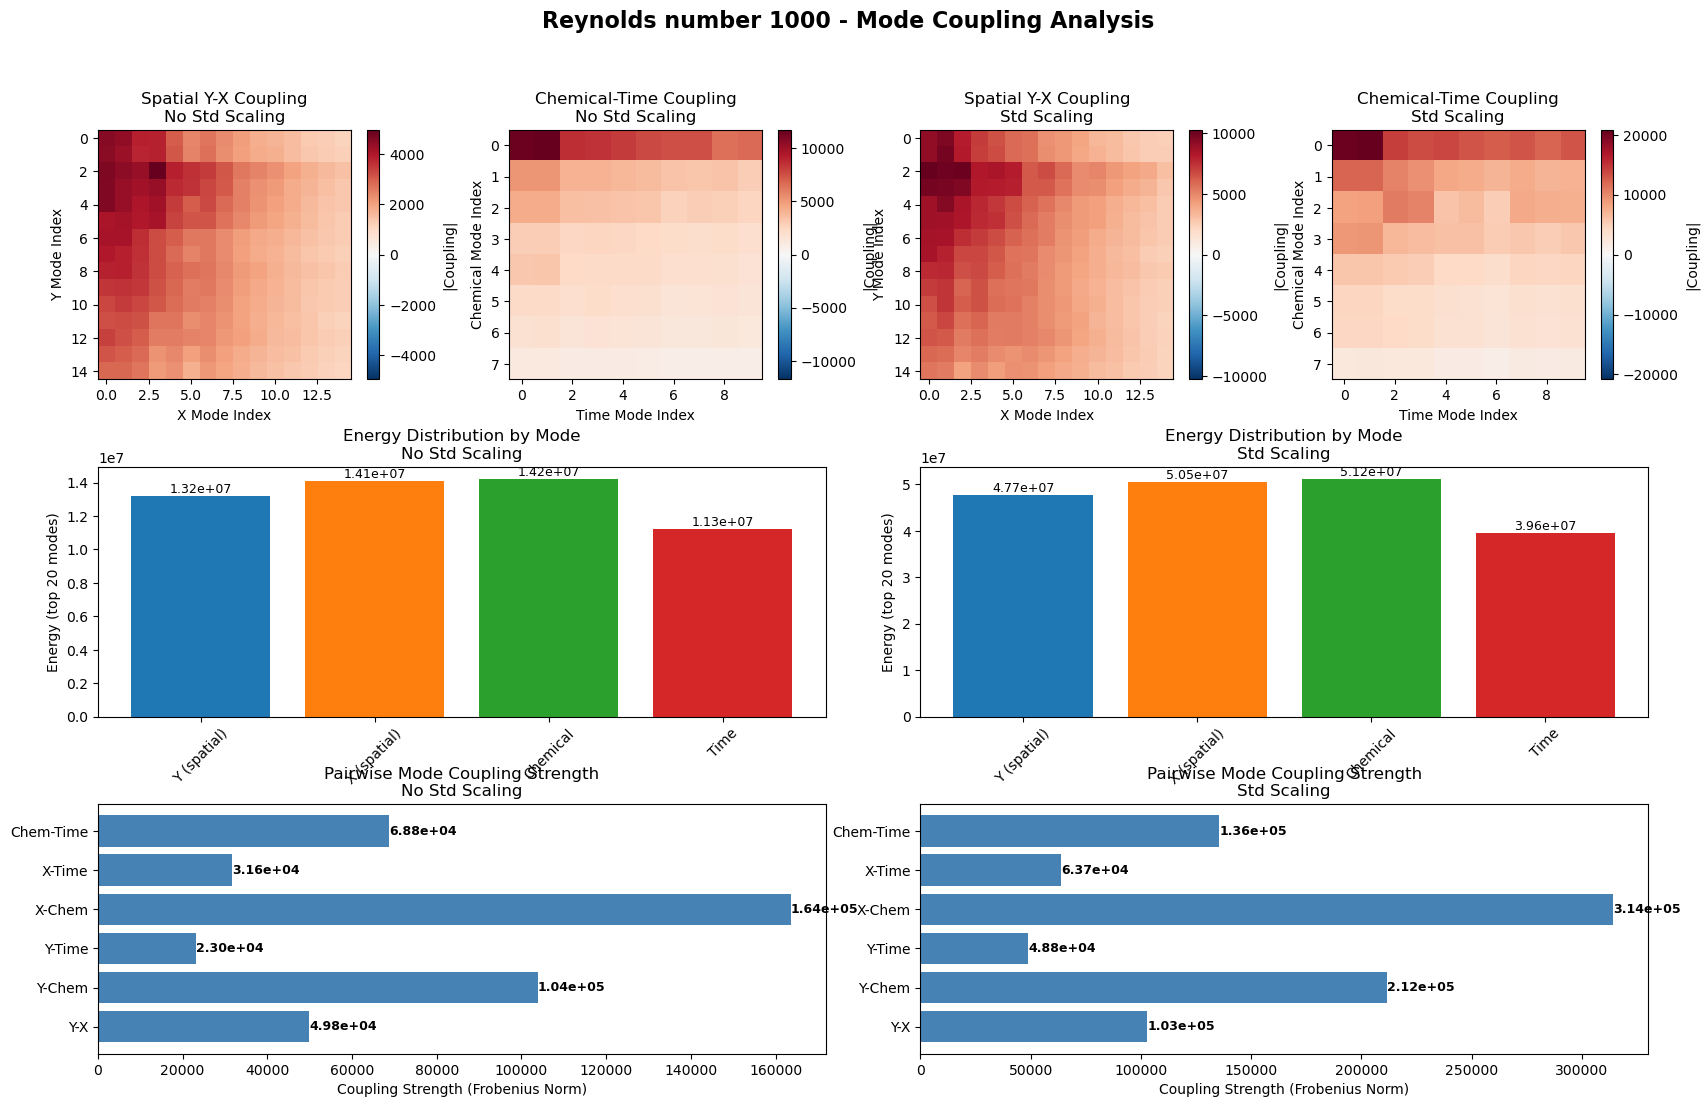


QUANTITATIVE METRICS: Reynolds number 1000

No Std Scaling:
--------------------------------------------------------------------------------
  Core tensor shape: (200, 160, 8, 200)
  Sparsity (% below 1% of max): 99.99%
  Spatial diagonal dominance: 0.0231

  Energy concentration:
    90% energy in 37293 components (0.073%)
    95% energy in 134579 components (0.263%)
    99% energy in 829239 components (1.620%)

  Effective ranks of mode couplings:
    spatial_y_x: 3.83 (top 10 modes: 100.0% energy)
    spatial_y_chem: 1.73 (top 10 modes: 100.0% energy)
    spatial_y_time: 16.08 (top 10 modes: 99.4% energy)
    spatial_x_chem: 2.32 (top 10 modes: 100.0% energy)
    spatial_x_time: 4.61 (top 10 modes: 100.0% energy)
    chem_time: 1.72 (top 10 modes: 100.0% energy)

Std Scaling:
--------------------------------------------------------------------------------
  Core tensor shape: (200, 160, 8, 200)
  Sparsity (% below 1% of max): 99.98%
  Spatial diagonal dominance: 0.0241

  Energy co

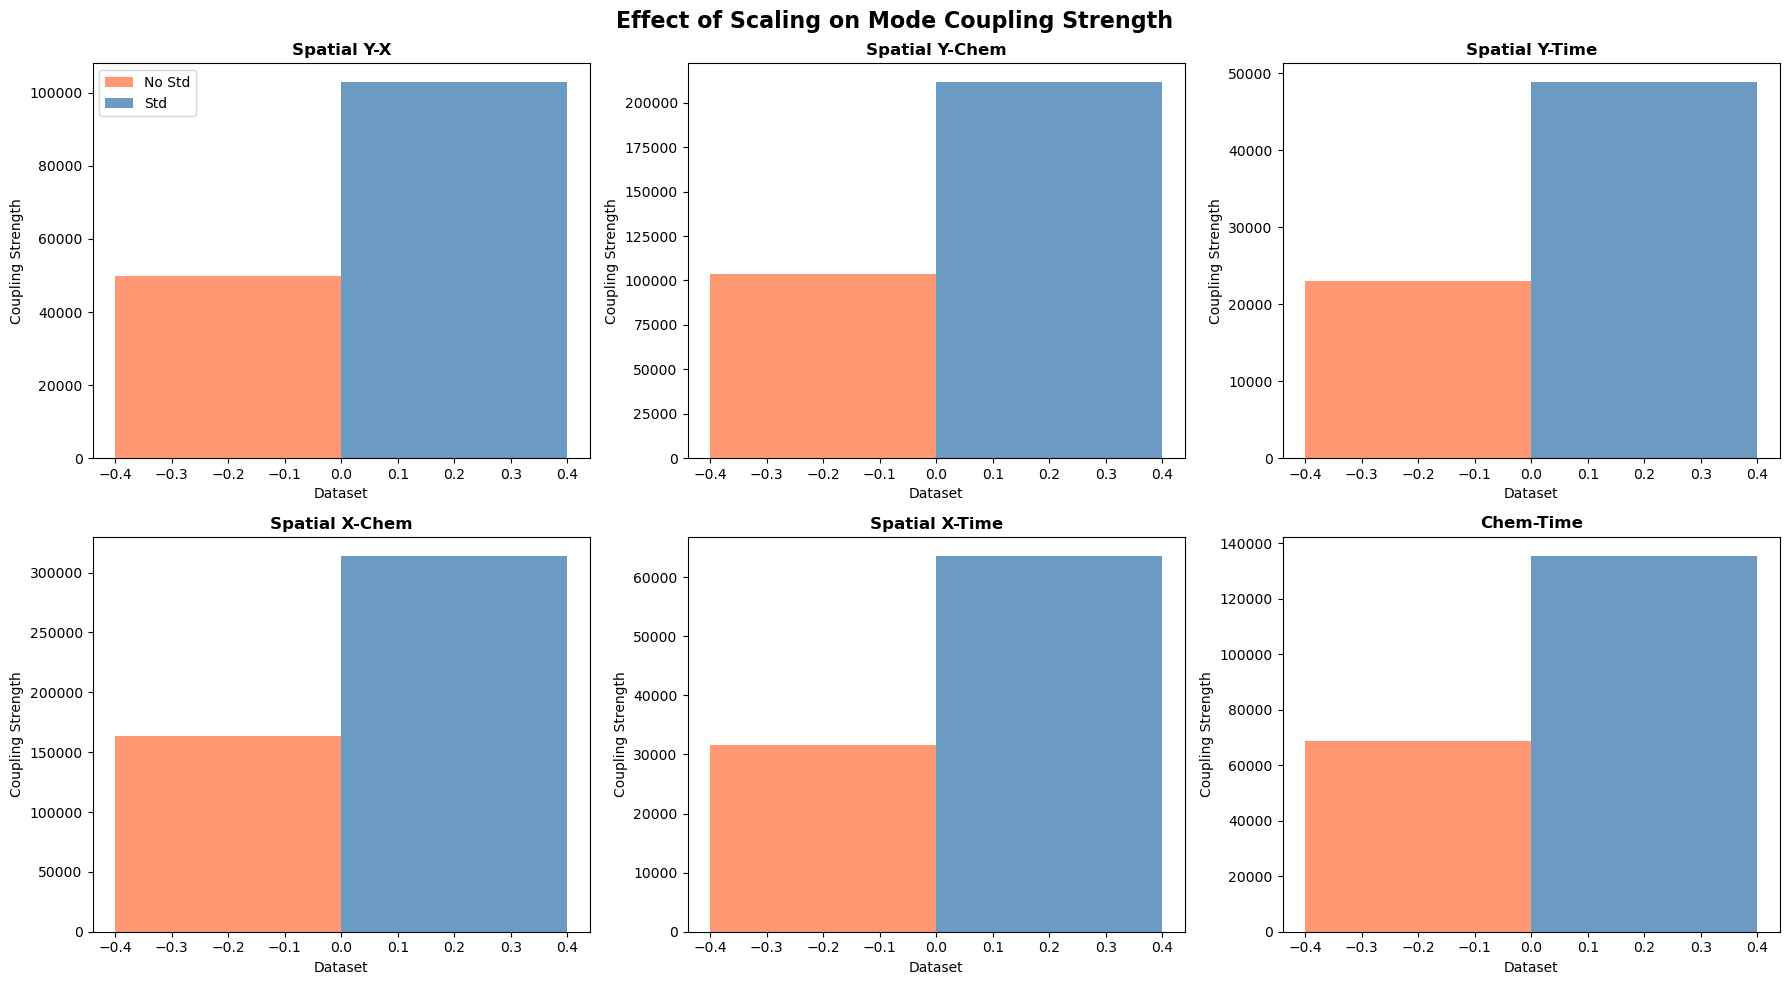

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

def compute_coupling_metrics(core_tensor):
    """
    Compute various coupling metrics for a core tensor.
    
    Parameters:
    -----------
    core_tensor : ndarray
        The core tensor from HOSVD decomposition
        Shape: (Ny, Nx, n_chem, n_time)
    
    Returns:
    --------
    metrics : dict
        Dictionary containing various coupling metrics
    """
    metrics = {}
    
    # 1. Mode energy distribution (how energy is distributed across each mode)
    for mode_idx in range(core_tensor.ndim):
        mode_energy = np.sum(core_tensor**2, axis=tuple(i for i in range(core_tensor.ndim) if i != mode_idx))
        metrics[f'mode_{mode_idx}_energy'] = mode_energy
        metrics[f'mode_{mode_idx}_energy_ratio'] = mode_energy / np.sum(core_tensor**2)
    
    # 2. Pairwise mode coupling strength (sum over other modes)
    mode_pairs = [(0, 1, 'spatial_y_x'), (0, 2, 'spatial_y_chem'), 
                  (0, 3, 'spatial_y_time'), (1, 2, 'spatial_x_chem'),
                  (1, 3, 'spatial_x_time'), (2, 3, 'chem_time')]
    
    for mode_i, mode_j, name in mode_pairs:
        other_modes = tuple(k for k in range(core_tensor.ndim) if k not in [mode_i, mode_j])
        coupling_matrix = np.sum(np.abs(core_tensor), axis=other_modes)
        metrics[f'coupling_{name}'] = coupling_matrix
        
        # Frobenius norm of coupling matrix
        metrics[f'coupling_{name}_norm'] = np.linalg.norm(coupling_matrix, 'fro')
        
        # Effective rank (using singular values)
        s = np.linalg.svd(coupling_matrix, compute_uv=False)
        s_normalized = s / np.sum(s)
        metrics[f'coupling_{name}_effective_rank'] = np.exp(entropy(s_normalized))
        metrics[f'coupling_{name}_top10_energy'] = np.sum(s[:10]**2) / np.sum(s**2)
    
    # 3. Diagonal dominance (measures separability)
    # For spatial modes (Y, X)
    spatial_slice = np.sum(np.abs(core_tensor), axis=(2, 3))
    diagonal_sum = np.sum(np.diag(spatial_slice[:min(spatial_slice.shape), :min(spatial_slice.shape)]))
    total_sum = np.sum(spatial_slice)
    metrics['spatial_diagonal_dominance'] = diagonal_sum / total_sum
    
    # 4. Sparsity measure (percentage of core elements below threshold)
    threshold = 0.01 * np.max(np.abs(core_tensor))
    metrics['sparsity'] = np.sum(np.abs(core_tensor) < threshold) / core_tensor.size
    
    # 5. Core tensor concentration (what % of energy in top k modes)
    core_flat = np.abs(core_tensor.flatten())
    core_sorted = np.sort(core_flat)[::-1]
    cumsum = np.cumsum(core_sorted**2)
    total_energy = cumsum[-1]
    
    for percentile in [90, 95, 99]:
        idx = np.searchsorted(cumsum, (percentile/100) * total_energy)
        metrics[f'energy_{percentile}%_components'] = idx
        metrics[f'energy_{percentile}%_ratio'] = idx / len(core_flat)
    
    return metrics


def visualize_coupling_comprehensive(decomposition_results, dataset_groups, figsize=(20, 12)):
    """
    Create comprehensive visualization of mode coupling.
    """
    
    for idx, (base_key, variants) in enumerate(dataset_groups.items()):
        dataset_name = f"Reynolds number {base_key.split('-')[-1][:4]}"
        
        # Create figure with subplots
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(3, 4, hspace=0.35, wspace=0.3)
        
        for var_idx, (variant_name, variant_data) in enumerate(variants.items()):
            core = variant_data['core']
            metrics = compute_coupling_metrics(core)
            
            col_offset = var_idx * 2
            scaling_label = "No Std Scaling" if "nostd" in variant_name else "Std Scaling"
            
            # 1. Spatial coupling (Y-X)
            ax1 = fig.add_subplot(gs[0, col_offset])
            spatial_coupling = metrics['coupling_spatial_y_x'][:15, :15]
            im1 = ax1.imshow(spatial_coupling, cmap='RdBu_r', aspect='auto',
                            vmin=-np.abs(spatial_coupling).max(),
                            vmax=np.abs(spatial_coupling).max())
            ax1.set_xlabel('X Mode Index')
            ax1.set_ylabel('Y Mode Index')
            ax1.set_title(f'Spatial Y-X Coupling\n{scaling_label}')
            plt.colorbar(im1, ax=ax1, label='|Coupling|')
            
            # 2. Chemical-Time coupling
            ax2 = fig.add_subplot(gs[0, col_offset+1])
            chem_time_coupling = metrics['coupling_chem_time'][:10, :10]
            im2 = ax2.imshow(chem_time_coupling, cmap='RdBu_r', aspect='auto',
                            vmin=-np.abs(chem_time_coupling).max(),
                            vmax=np.abs(chem_time_coupling).max())
            ax2.set_xlabel('Time Mode Index')
            ax2.set_ylabel('Chemical Mode Index')
            ax2.set_title(f'Chemical-Time Coupling\n{scaling_label}')
            plt.colorbar(im2, ax=ax2, label='|Coupling|')
            
            # 3. Mode energy distribution
            ax3 = fig.add_subplot(gs[1, col_offset:col_offset+2])
            mode_names = ['Y (spatial)', 'X (spatial)', 'Chemical', 'Time']
            mode_energies = [np.sum(metrics[f'mode_{i}_energy'][:20]) for i in range(4)]
            bars = ax3.bar(mode_names, mode_energies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
            ax3.set_ylabel('Energy (top 20 modes)')
            ax3.set_title(f'Energy Distribution by Mode\n{scaling_label}')
            ax3.tick_params(axis='x', rotation=45)
            
            # Add values on bars
            for bar in bars:
                height = bar.get_height()
                ax3.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.2e}',
                        ha='center', va='bottom', fontsize=9)
            
            # 4. Coupling strength comparison
            ax4 = fig.add_subplot(gs[2, col_offset:col_offset+2])
            coupling_names = ['Y-X', 'Y-Chem', 'Y-Time', 'X-Chem', 'X-Time', 'Chem-Time']
            coupling_keys = ['spatial_y_x', 'spatial_y_chem', 'spatial_y_time', 
                           'spatial_x_chem', 'spatial_x_time', 'chem_time']
            coupling_strengths = [metrics[f'coupling_{key}_norm'] for key in coupling_keys]
            
            bars = ax4.barh(coupling_names, coupling_strengths, color='steelblue')
            ax4.set_xlabel('Coupling Strength (Frobenius Norm)')
            ax4.set_title(f'Pairwise Mode Coupling Strength\n{scaling_label}')
            
            # Add values on bars
            for bar in bars:
                width = bar.get_width()
                ax4.text(width, bar.get_y() + bar.get_height()/2.,
                        f'{width:.2e}',
                        ha='left', va='center', fontsize=9, fontweight='bold')
        
        fig.suptitle(f'{dataset_name} - Mode Coupling Analysis', 
                    fontsize=16, fontweight='bold', y=0.98)
        plt.show()
        
        # Print quantitative metrics
        print("\n" + "="*100)
        print(f"QUANTITATIVE METRICS: {dataset_name}")
        print("="*100)
        
        for variant_name, variant_data in variants.items():
            core = variant_data['core']
            metrics = compute_coupling_metrics(core)
            scaling_label = "No Std Scaling" if "nostd" in variant_name else "Std Scaling"
            
            print(f"\n{scaling_label}:")
            print("-" * 80)
            print(f"  Core tensor shape: {core.shape}")
            print(f"  Sparsity (% below 1% of max): {metrics['sparsity']*100:.2f}%")
            print(f"  Spatial diagonal dominance: {metrics['spatial_diagonal_dominance']:.4f}")
            print(f"\n  Energy concentration:")
            print(f"    90% energy in {metrics['energy_90%_components']} components ({metrics['energy_90%_ratio']*100:.3f}%)")
            print(f"    95% energy in {metrics['energy_95%_components']} components ({metrics['energy_95%_ratio']*100:.3f}%)")
            print(f"    99% energy in {metrics['energy_99%_components']} components ({metrics['energy_99%_ratio']*100:.3f}%)")
            
            print(f"\n  Effective ranks of mode couplings:")
            for key in ['spatial_y_x', 'spatial_y_chem', 'spatial_y_time', 
                       'spatial_x_chem', 'spatial_x_time', 'chem_time']:
                print(f"    {key}: {metrics[f'coupling_{key}_effective_rank']:.2f} " +
                      f"(top 10 modes: {metrics[f'coupling_{key}_top10_energy']*100:.1f}% energy)")


def compare_scaling_effects(decomposition_results, dataset_groups):
    """
    Create comparison plots showing effect of scaling on coupling.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    coupling_keys = ['spatial_y_x', 'spatial_y_chem', 'spatial_y_time', 
                     'spatial_x_chem', 'spatial_x_time', 'chem_time']
    titles = ['Spatial Y-X', 'Spatial Y-Chem', 'Spatial Y-Time',
              'Spatial X-Chem', 'Spatial X-Time', 'Chem-Time']
    
    for idx, (base_key, variants) in enumerate(dataset_groups.items()):
        dataset_name = f"Re {base_key.split('-')[-1][:4]}"
        
        nostd_metrics = compute_coupling_metrics(variants['nostd']['core']) if 'nostd' in variants else None
        std_metrics = compute_coupling_metrics(variants['std']['core']) if 'std' in variants else None
        
        for ax_idx, (key, title) in enumerate(zip(coupling_keys, titles)):
            ax = axes[ax_idx // 3, ax_idx % 3]
            
            x_pos = idx
            if nostd_metrics:
                ax.bar(x_pos - 0.2, nostd_metrics[f'coupling_{key}_norm'], 
                      width=0.4, label='No Std' if idx == 0 else '', color='coral', alpha=0.8)
            if std_metrics:
                ax.bar(x_pos + 0.2, std_metrics[f'coupling_{key}_norm'], 
                      width=0.4, label='Std' if idx == 0 else '', color='steelblue', alpha=0.8)
            
            ax.set_title(title, fontweight='bold')
            ax.set_xlabel('Dataset')
            ax.set_ylabel('Coupling Strength')
            if ax_idx == 0:
                ax.legend()
    
    plt.suptitle('Effect of Scaling on Mode Coupling Strength', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Run the analysis
print("Computing coupling metrics and creating visualizations...")
visualize_coupling_comprehensive(decomposition_results, dataset_groups)
compare_scaling_effects(decomposition_results, dataset_groups)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def reconstruct_with_mode_coupling(core, factors, mode_pairs, n_modes_per_pair):
    """
    Reconstruct tensor using only specific mode pair couplings.
    
    Parameters:
    -----------
    core : ndarray
        Core tensor from HOSVD
    factors : list
        List of factor matrices [U_y, U_x, U_chem, U_time]
    mode_pairs : list of tuples
        Which mode pairs to include, e.g., [(0,1), (2,3)]
    n_modes_per_pair : dict
        Number of modes to keep for each pair, e.g., {(0,1): 10, (2,3): 5}
    
    Returns:
    --------
    reconstructed : ndarray
        Reconstructed tensor
    """
    # Create a masked core tensor
    core_masked = np.zeros_like(core)
    
    # Only keep specified mode pair interactions
    for pair in mode_pairs:
        n_modes = n_modes_per_pair.get(pair, 5)
        mode_i, mode_j = pair
        
        # Create index slices for all modes
        slices = [slice(None)] * core.ndim
        slices[mode_i] = slice(0, n_modes)
        slices[mode_j] = slice(0, n_modes)
        
        # Copy the coupling terms
        core_masked[tuple(slices)] = core[tuple(slices)]
    
    # Reconstruct using Tucker decomposition formula with multi_mode_dot
    reconstructed = multi_mode_dot(core_masked, factors, modes=[0, 1, 2, 3])
    
    return reconstructed


def visualize_chemical_coupling_on_flame(decomposition_results, dataset_groups, 
                                         time_idx=0, save_dir='./chemical_coupling_analysis'):
    """
    Visualize how chemical mode couplings contribute to flame structure.
    Focus on: Y-Chem, X-Chem, and Chem-Time interactions.
    """
    import os
    os.makedirs(save_dir, exist_ok=True)
    
    for base_key, variants in dataset_groups.items():
        dataset_name = f"Reynolds number {base_key.split('-')[-1][:4]}"
        
        for variant_name, variant_data in variants.items():
            scaling_label = "No Std Scaling" if "nostd" in variant_name else "Std Scaling"
            
            core = variant_data['core']
            factors = variant_data['factors']
            n_chem = core.shape[2]
            
            # Full reconstruction (all modes)
            full_recon = multi_mode_dot(core, factors, modes=[0, 1, 2, 3])
            
            # Chemical coupling scenarios
            coupling_scenarios = {
                'Y-Chemical (8 modes)': {
                    'pairs': [(0, 2)],
                    'n_modes': {(0, 2): 8}
                },
                'X-Chemical (8 modes)': {
                    'pairs': [(1, 2)],
                    'n_modes': {(1, 2): 8}
                },
                'Spatial-Chemical (Y&X-Chem, 8 modes)': {
                    'pairs': [(0, 2), (1, 2)],
                    'n_modes': {(0, 2): 8, (1, 2): 8}
                },
                'Chemical-Time (5 modes)': {
                    'pairs': [(2, 3)],
                    'n_modes': {(2, 3): 5}
                },
                'All Chemical Couplings (10 modes)': {
                    'pairs': [(0, 2), (1, 2), (2, 3)],
                    'n_modes': {(0, 2): 10, (1, 2): 10, (2, 3): 10}
                }
            }
            
            # Create figure - one row per chemical species (show first 3 species)
            n_species_to_show = min(3, n_chem)
            fig = plt.figure(figsize=(24, 6 * n_species_to_show))
            gs = GridSpec(n_species_to_show, 6, figure=fig, hspace=0.35, wspace=0.3)
            
            for species_idx in range(n_species_to_show):
                # Full reconstruction for this species
                ax_full = fig.add_subplot(gs[species_idx, 0])
                flame_slice_full = full_recon[:, :, species_idx, time_idx]
                im_full = ax_full.imshow(flame_slice_full, cmap='hot', aspect='auto', origin='lower')
                ax_full.set_title(f'Species {species_idx}\nFull Reconstruction', fontweight='bold', fontsize=11)
                ax_full.set_xlabel('X')
                ax_full.set_ylabel('Y')
                plt.colorbar(im_full, ax=ax_full, label='Value')
                
                # Plot each chemical coupling scenario
                for idx, (scenario_name, scenario_params) in enumerate(coupling_scenarios.items()):
                    col = idx + 1
                    ax = fig.add_subplot(gs[species_idx, col])
                    
                    # Reconstruct with specific couplings
                    recon = reconstruct_with_mode_coupling(
                        core, factors, 
                        scenario_params['pairs'],
                        scenario_params['n_modes']
                    )
                    
                    flame_slice_recon = recon[:, :, species_idx, time_idx]
                    
                    im = ax.imshow(flame_slice_recon, cmap='hot', aspect='auto', origin='lower',
                                  vmin=flame_slice_full.min(), vmax=flame_slice_full.max())
                    ax.set_title(scenario_name, fontweight='bold', fontsize=10)
                    ax.set_xlabel('X')
                    ax.set_ylabel('Y')
                    plt.colorbar(im, ax=ax, label='Value')
                    
                    # Compute relative error
                    rel_error = np.linalg.norm(flame_slice_full - flame_slice_recon) / np.linalg.norm(flame_slice_full)
                    ax.text(0.02, 0.98, f'Error: {rel_error:.3f}',
                           transform=ax.transAxes, fontsize=9,
                           verticalalignment='top', bbox=dict(boxstyle='round', 
                           facecolor='white', alpha=0.8))
            
            fig.suptitle(f'{dataset_name} - {scaling_label}\nChemical Coupling Effects (t={time_idx})',
                        fontsize=18, fontweight='bold')
            
            # Save figure
            dataset_clean = base_key.split('/')[-1].replace('.nc', '')
            filename = f'{dataset_clean}_{variant_name}_chemical_coupling_analysis.png'
            filepath = os.path.join(save_dir, filename)
            plt.savefig(filepath, dpi=300, bbox_inches='tight')
            print(f"Saved: {filepath}")
            plt.close(fig)


def compare_chemical_coupling_errors(decomposition_results, dataset_groups,
                                     time_idx=0, save_dir='./chemical_coupling_analysis'):
    """
    Create error comparison plots for chemical couplings across species and datasets.
    """
    import os
    os.makedirs(save_dir, exist_ok=True)
    
    coupling_scenarios = {
        'Y-Chem': [(0, 2)],
        'X-Chem': [(1, 2)],
        'Spatial-Chem': [(0, 2), (1, 2)],
        'Chem-Time': [(2, 3)],
        'All Chem': [(0, 2), (1, 2), (2, 3)]
    }
    
    n_modes = 8
    
    fig, axes = plt.subplots(len(dataset_groups), 2, figsize=(16, 6 * len(dataset_groups)))
    if len(dataset_groups) == 1:
        axes = axes.reshape(1, -1)
    
    for ds_idx, (base_key, variants) in enumerate(dataset_groups.items()):
        dataset_name = f"Re {base_key.split('-')[-1][:4]}"
        
        for var_idx, (variant_name, variant_data) in enumerate(variants.items()):
            ax = axes[ds_idx, var_idx]
            scaling_label = "No Std" if "nostd" in variant_name else "Std"
            
            core = variant_data['core']
            factors = variant_data['factors']
            n_chem = core.shape[2]
            
            # Full reconstruction
            full_recon = multi_mode_dot(core, factors, modes=[0, 1, 2, 3])
            
            # Compute errors for each scenario and species
            errors = {scenario: [] for scenario in coupling_scenarios.keys()}
            
            for species_idx in range(min(n_chem, 5)):  # First 5 species
                flame_slice_full = full_recon[:, :, species_idx, time_idx]
                
                for scenario_name, pairs in coupling_scenarios.items():
                    n_modes_dict = {pair: n_modes for pair in pairs}
                    recon = reconstruct_with_mode_coupling(core, factors, pairs, n_modes_dict)
                    flame_slice_recon = recon[:, :, species_idx, time_idx]
                    
                    rel_error = np.linalg.norm(flame_slice_full - flame_slice_recon) / np.linalg.norm(flame_slice_full)
                    errors[scenario_name].append(rel_error)
            
            # Plot
            x = np.arange(len(errors[list(errors.keys())[0]]))
            width = 0.15
            
            for idx, (scenario_name, error_values) in enumerate(errors.items()):
                offset = (idx - 2) * width
                ax.bar(x + offset, error_values, width, label=scenario_name, alpha=0.8)
            
            ax.set_xlabel('Chemical Species Index', fontsize=12)
            ax.set_ylabel('Relative Error', fontsize=12)
            ax.set_title(f'{dataset_name} - {scaling_label}', fontweight='bold', fontsize=13)
            ax.set_xticks(x)
            ax.set_xticklabels([f'Sp{i}' for i in range(len(x))])
            ax.legend(fontsize=9)
            ax.grid(axis='y', alpha=0.3)
    
    fig.suptitle('Chemical Coupling Reconstruction Errors Across Species',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    filename = 'chemical_coupling_error_comparison.png'
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")
    plt.close(fig)


# Run the analysis
print("Visualizing chemical coupling effects on flame structure...")
visualize_chemical_coupling_on_flame(decomposition_results, dataset_groups, time_idx=0)
compare_chemical_coupling_errors(decomposition_results, dataset_groups, time_idx=0)

Visualizing chemical coupling effects on flame structure...


Saved: ./chemical_coupling_analysis/hydrogen-jet-10000_nostd_chemical_coupling_analysis.png
Saved: ./chemical_coupling_analysis/hydrogen-jet-10000_std_chemical_coupling_analysis.png
Saved: ./chemical_coupling_analysis/chemical_coupling_error_comparison.png
